In [16]:
import gdown
import requests
import zipfile
from functools import partial
from pathlib import Path
import rasterio as rio
from matplotlib import pyplot as plt
from ocm import (
    predict_from_load_func,
    predict_from_array,
    load_ls8,
    load_multiband,
    load_s2,
)

In [2]:
test_data_dir = Path("test data")
test_data_dir.mkdir(exist_ok=True)

In [9]:
test_data_liks = {
    "LC81960302014022LGN00": "1ewmbD2YzxUS2IibMW5GTbcQyZIoz0TNf",
    "S2B_MSIL1C_20180302T150259_N0206_R125_T22WES_20180302T183800.SAFE": "1pGu_RdboqYcK4Q6_kjpnynCSzmNdUgcW",
    "S2A_MSIL2A_20170725T142751_N9999_R053_T19GBQ_20240410T040247.SAFE": "1ZEfXnNpWi75OV6fVhNvzbe6MhxsvXSI3",
}

In [10]:
def download_file_from_google_drive(file_id: str, destination: Path) -> None:
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(destination), quiet=False)

In [11]:
for file_name, file_id in test_data_liks.items():
    zip_file = test_data_dir / f"{file_name}.zip"
    if not zip_file.exists():
        download_file_from_google_drive(file_id, zip_file)

    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        zip_ref.extractall(test_data_dir / file_name)

Downloading...
From (original): https://drive.google.com/uc?id=1ewmbD2YzxUS2IibMW5GTbcQyZIoz0TNf
From (redirected): https://drive.google.com/uc?id=1ewmbD2YzxUS2IibMW5GTbcQyZIoz0TNf&confirm=t&uuid=5f6e6554-9e38-46cc-8abb-845764e3139e
To: /home/nick/Documents/Work code/Planet-mask/test data/LC81960302014022LGN00.zip
100%|██████████| 860M/860M [00:22<00:00, 37.9MB/s] 


In [17]:
maxar_url = "https://maxar-opendata.s3.us-west-2.amazonaws.com/events/Emilia-Romagna-Italy-flooding-may23/ard/32/120000303231/2023-05-23/1050010033C95B00-ms.tif"
maxar_path = test_data_dir / "maxar.tif"
if not maxar_path.exists():
    with requests.get(maxar_url, stream=True) as response:
        with open(maxar_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

In [19]:
s2_l2a_Path = (
    test_data_dir / "S2A_MSIL2A_20170725T142751_N9999_R053_T19GBQ_20240410T040247.SAFE"
)
s2_l1c_Path = (
    test_data_dir / "S2B_MSIL1C_20180302T150259_N0206_R125_T22WES_20180302T183800.SAFE"
)
ls_path = test_data_dir / "LC81960302014022LGN00"
s2_l1c_Path.exists(), s2_l2a_Path.exists(), ls_path.exists()

(True, True, True)

In [20]:
s2_items = [s2_l2a_Path, s2_l1c_Path]
ls_items = [ls_path]

In [21]:
load_multiband_maxar = partial(load_multiband, resample_res=10, band_order=[1, 2, 4])

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda bfloat16:   0%|          | 0/2 [00:00<?, ?it/s]

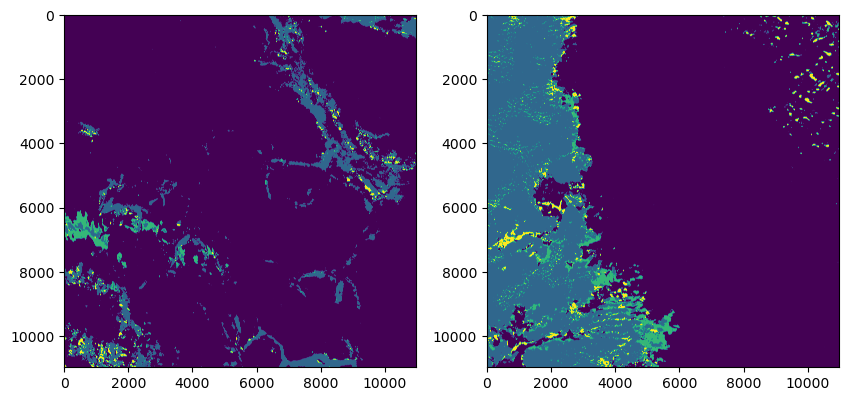

In [23]:
pred_paths = predict_from_load_func(
    load_func=load_s2, scene_paths=s2_items, inference_dtype="bf16", batch_size=4
)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for ax, path in zip(axs, pred_paths):
    with rio.open(path) as src:
        ax.imshow(src.read(1))
plt.show()

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda bfloat16:   0%|          | 0/1 [00:00<?, ?it/s]

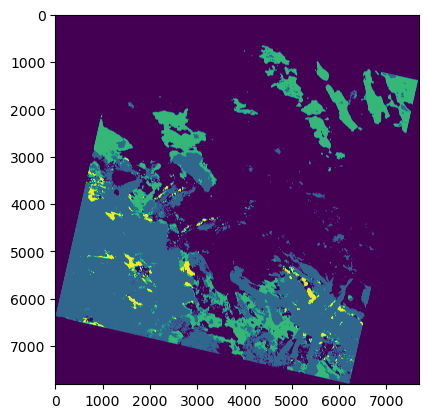

In [24]:
pred_paths = predict_from_load_func(
    load_func=load_ls8, scene_paths=ls_items, inference_dtype="bf16", batch_size=4
)

pred_array = rio.open(pred_paths[0]).read(1)
plt.imshow(pred_array, vmin=0, vmax=3)

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda bfloat16:   0%|          | 0/1 [00:00<?, ?it/s]

/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


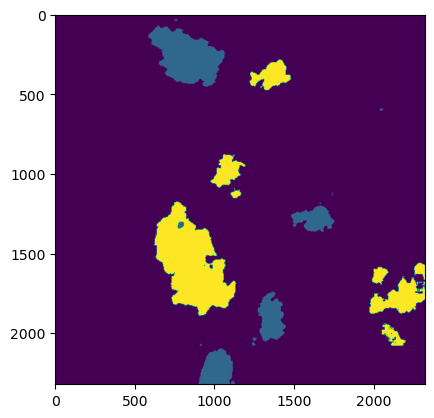

In [26]:
pred_paths = predict_from_load_func(
    load_func=load_multiband_maxar,
    scene_paths=[maxar_path],
    inference_dtype="bf16",
    batch_size=4,
)

pred_array = rio.open(pred_paths[0]).read(1)
plt.imshow(pred_array, vmin=0, vmax=3)

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda float32:   0%|          | 0/1 [00:00<?, ?it/s]

/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda float16:   0%|          | 0/1 [00:00<?, ?it/s]

/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda bfloat16:   0%|          | 0/1 [00:00<?, ?it/s]

/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


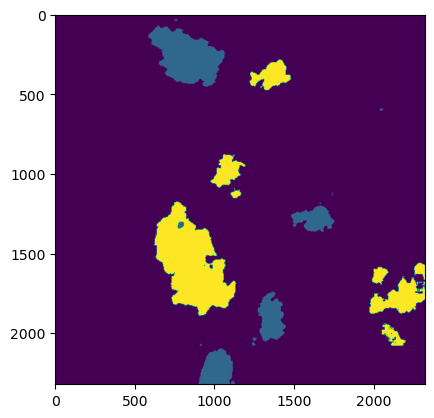

In [27]:
for dtype in ["float32", "float16", "bfloat16"]:
    pred_paths = predict_from_load_func(
        load_func=load_multiband_maxar,
        scene_paths=[maxar_path],
        inference_dtype=dtype,
        version=dtype,
        batch_size=4,
    )

pred_array = rio.open(pred_paths[0]).read(1)
plt.imshow(pred_array, vmin=0, vmax=3)

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cuda float32:   0%|          | 0/1 [00:00<?, ?it/s]

/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


Running inference using cpu float32:   0%|          | 0/1 [00:00<?, ?it/s]

/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


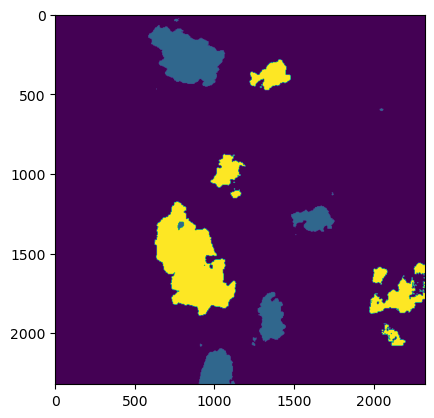

In [28]:
for device in ["cuda", "cpu"]:
    pred_paths = predict_from_load_func(
        load_func=load_multiband_maxar,
        scene_paths=[maxar_path],
        inference_device=device,
        version=device,
    )

pred_array = rio.open(pred_paths[0]).read(1)
plt.imshow(pred_array, vmin=0, vmax=3)

Loading PM_model_2.2.10_RG_NIR_509_convnextv2_nano.fcmae_ft_in1k_PT.pth
Loading PM_model_2.2.10_RG_NIR_509_regnety_004.pycls_in1k_PT.pth


/home/nick/Documents/Work code/Planet-mask/ocm/cloud_mask.py:147: UserWarning: Patch size too large, reducing to 531 and overlap to 265.
  warnings.warn(


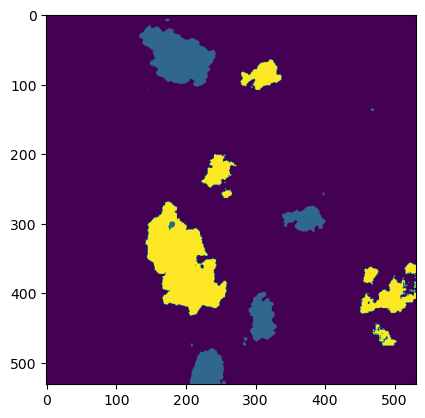

In [34]:
RGNIR_array = load_multiband_maxar(maxar_path)[0]
pred_array = predict_from_array(RGNIR_array)
plt.imshow(pred_array[0], vmin=0, vmax=3)